# Exploration

Now that the cleaning has been done, we will produce some visualizations to get insights about the target and the features before modelling.

### Target

In [1]:
import pandas as pd

file_path = "Data/exploration_data.csv"

data = pd.read_csv(file_path)



/home/marco/anaconda3/envs/health_app/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


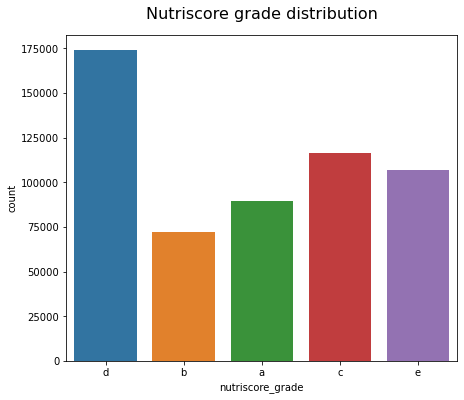

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

def target_plot(data):
    
    fig = plt.figure(figsize = (7,6))
    g = fig.add_subplot(111)
    g = sns.countplot(data['nutriscore_grade'])
    g.set_title('Nutriscore grade distribution', fontsize = 16, pad = 16)
    
target_plot(data)

Globally the distribution of the target labels can be considerered as unbalanced, considering  d class is overrepresented.

However the distribution between other classes is fairly balanced, and there is no minority class with very few samples.

Over or undersampling prior to classification will not be needed here.

### Is nutriscore a good health indicator ?

Before building a classifier we should check whether nutriscore may be considered a good health indicator. 

We will answer this question two-fold : 
- we will show that target continuous feature gives the same information as its categorical counterpart ie quantify correlation between both (appropriate test here would be Spearman test that does not imply continuous and normal distributions)


- we will test correlation between target and:
    - fibers (healthy)
    - saturated fat & sugars (not healthy)
    - correlation coefficient should be opposite

stat=-0.960, p=0.000 : nutriscore grade is likely the discretization of continuous nutriscore


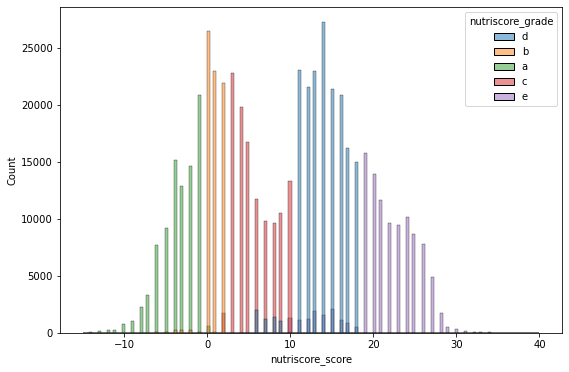

In [3]:
import category_encoders as ce
from scipy.stats import shapiro, spearmanr
import numpy as np

### function that computes spearman test between the two nutriscore variables

def nutriscore_spearman(data):
    
    
    data = data.copy()
    
    ### encoding nutriscore_grade feature as an ordinal variable
    ### A = 5 the better & E = 1 the worse
    mapper = {'a' : 5, 'b' : 4, 'c' : 3, 'd' : 2, 'e' : 1}
    enc = ce.OrdinalEncoder(mapping = [{'col' : 'nutriscore_grade',
                'mapping' : lambda grade : mapper[grade]}])
    
    encoded_labels = enc.fit_transform(data['nutriscore_grade'])
    
    ### Compute Spearman test between two nutriscore variables
    stat, p = spearmanr(encoded_labels,data['nutriscore_score'])
    if np.abs(stat) > 0.95:
        print('stat=%.3f, p=%.3f' % 
                        (stat, p) + ' : nutriscore grade is likely the discretization' +  
              ' of continuous nutriscore')
            
    else:
        print('stat=%.3f, p=%.3f' % (stat, p) 
            + ' : features probably dependent')
        
        
    fig = plt.figure(figsize = (9,6))
    g = fig.add_subplot(111)
    g = sns.histplot(x = 'nutriscore_score', hue = 'nutriscore_grade', 
        data = data)
    

nutriscore_spearman(data)

Now that we assume the perfect correlation between the two target variables, 
we want to test the correlation degree and direction between the target and some of the features.

Two statistical tests could help us : 
- Pearson which quantifies linear correalation between features
- Spearman as done above, which more generally quantifies monotonous relations

Pearson assumes continuous and normal distributions for the features to test.
We may then apply a Shapiro normality test to test whether our distributions are or not normal.

nutriscore_score: stat=0.975, p=0.000 conclusion : probably not Gaussian
energy_100g: stat=0.961, p=0.000 conclusion : probably not Gaussian
proteins_100g: stat=0.824, p=0.000 conclusion : probably not Gaussian
sugars_100g: stat=0.738, p=0.000 conclusion : probably not Gaussian
salt_100g: stat=0.234, p=0.000 conclusion : probably not Gaussian
saturated-fat_100g: stat=0.697, p=0.000 conclusion : probably not Gaussian
fiber_100g: stat=0.641, p=0.000 conclusion : probably not Gaussian


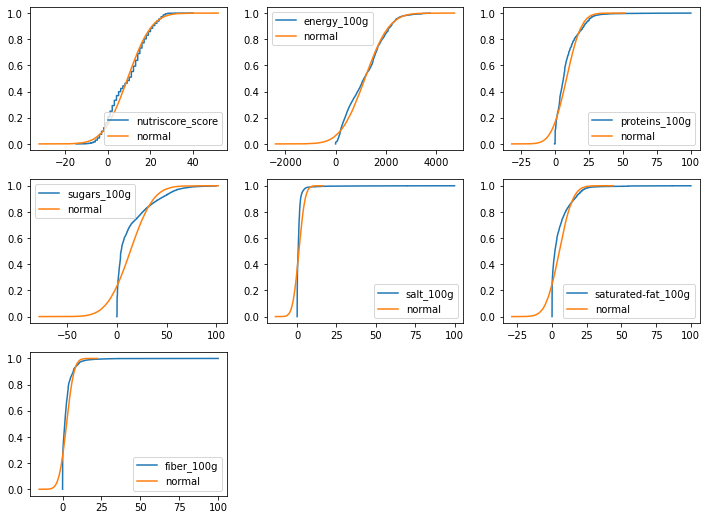

In [4]:
### A warning prevents that p-value may not be accurate with N > 5000 
import warnings
from scipy.stats import shapiro
warnings.filterwarnings('ignore')



def normality_cum_distrib_plots(data):
    
    features = data.columns[data.dtypes == 'float64'].tolist()
    
    ### Remove binary feature
    features.remove('pnns_groups_1')
    
    ### y represents cumulative proportion of data 
    n = len(data)
    y = np.arange(1,n+1)/n
    
    fig = plt.figure(figsize = (12,9))
    
    
    for i, feature in enumerate(features):
        stat, p = shapiro(data[feature])
        if p > 0.05:
            print(feature + ': ' + 'stat=%.3f, p=%.3f' % 
                        (stat, p) + 'conclusion : probably Gaussian')
            
        else:
            print(feature + ': ' + 'stat=%.3f, p=%.3f' % 
                        (stat, p) + ' conclusion : probably not Gaussian') 
            
        
        ### normal distribution with same parameters -mean, std & shape' as feature distribution
        normal_distrib = np.random.normal(data[feature].mean(), 
                    data[feature].std(), n)
        
        ax = fig.add_subplot(3,3,i+1)
        
        ### plots cumulative distribution of normal disttribution & current feature
        ax.plot(sorted(data[feature]), y, label = feature)
        ax.plot(sorted(normal_distrib), y, label = 'normal')
        ax.legend()
    
    
normality_cum_distrib_plots(data) 

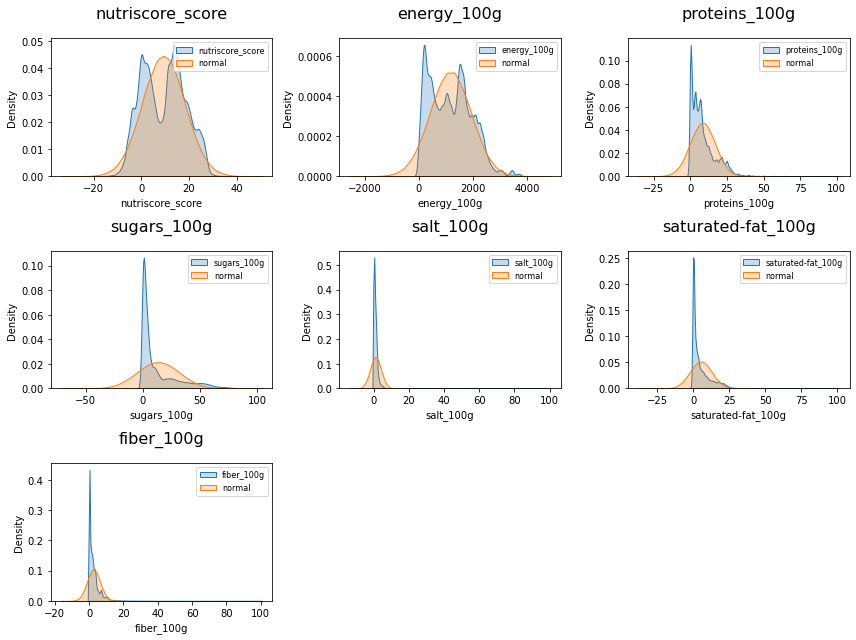

In [5]:
def normal_density(data):
    
    features = data.columns[data.dtypes == 'float64'].tolist()
    
    ### Remove binary feature
    features.remove('pnns_groups_1')
    
    ### y represents cumulative proportion of data 
    n = len(data)
    y = np.arange(1,n+1)/n
    
    fig = plt.figure(figsize = (12,9))
    
    
    for i, feature in enumerate(features):
        
        ### normal distribution with same parameters -mean, std & shape' as feature distribution
        normal_dist = np.random.normal(data[feature].mean(), 
                    data[feature].std(), n)
        
        g = fig.add_subplot(3,3,i+1)
        
        ### plots cumulative distribution of normal disttribution & current feature
        g = sns.kdeplot(data[feature], shade = True)
        g = sns.kdeplot(normal_dist, shade = True)
        g.set_title(feature, fontsize = 16, pad = 20)
        g.legend([feature, 'normal'], fontsize = 8)
        
    fig.tight_layout()
        
normal_density(data)

Since distributions are not Gaussian we will take Spearman test between nutriscore and : 
- fibers
- saturated fat
- sugars

Assuming that fibers are good for health whereas saturated fat & sugars are bad, the correlation coefficient sign should be the opposite for fibers vs the rest.

In [6]:


def spearman_test(data, features):
    
    
    fig = plt.figure(figsize = (9,6))
    
    for i, feature in enumerate(features):
        
        stat, p = spearmanr(data['nutriscore_score'],data[feature])
        if p > 0.05:
            print(feature + ': ' + 'stat=%.3f, p=%.3f' % 
                        (stat, p) + 'conclusion : probably independent')
            
        else:
            print(feature + ': ' + 'stat=%.3f, p=%.3f' % (stat, p) 
            + ' conclusion : probably dependent') 
        
        g = fig.add_subplot(len(features), 1, i+1)
        g = sns.regplot(x = feature, y = 'nutriscore_score', 
        data = data, scatter_kws={'alpha':0.05}, ci = 99, line_kws= {'lw': 5})
        
        g.set_title(feature + ' vs nutriscore', fontsize = 20, pad = 20)
        g.set_xlabel(xlabel = feature, fontsize = 16)
        g.set_ylabel(ylabel = 'nutriscore', fontsize = 16)
        g.legend(['Spearman ρ = %.3f' % stat], fontsize = 20)
        
    fig.tight_layout()

fiber_100g: stat=-0.108, p=0.000 conclusion : probably dependent


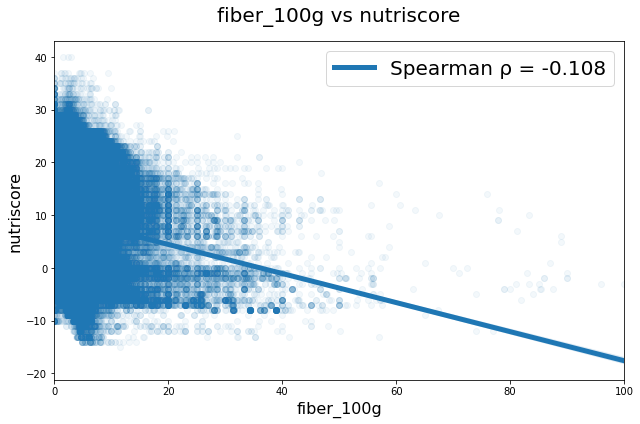

In [7]:
spearman_test(data, ['fiber_100g'])

saturated-fat_100g: stat=0.661, p=0.000 conclusion : probably dependent


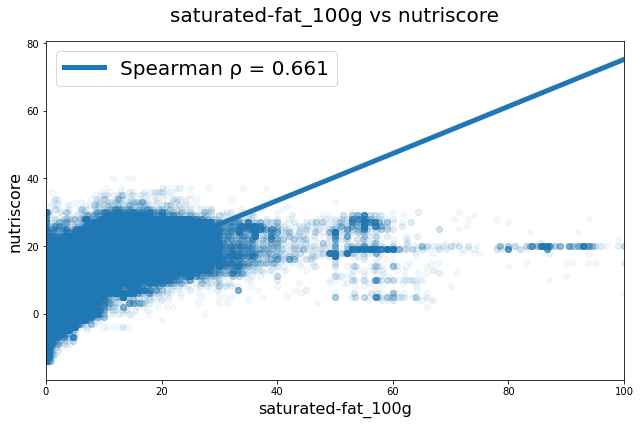

In [8]:
spearman_test(data, ['saturated-fat_100g'])

sugars_100g: stat=0.342, p=0.000 conclusion : probably dependent


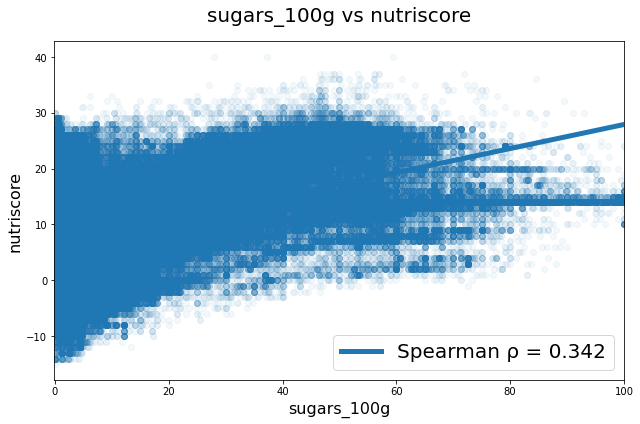

In [9]:
spearman_test(data, ['sugars_100g'])

### Features 

As nutriscore can be considered a good indicator, we will now explore visually the relationship between the target and features.

#### Univariate

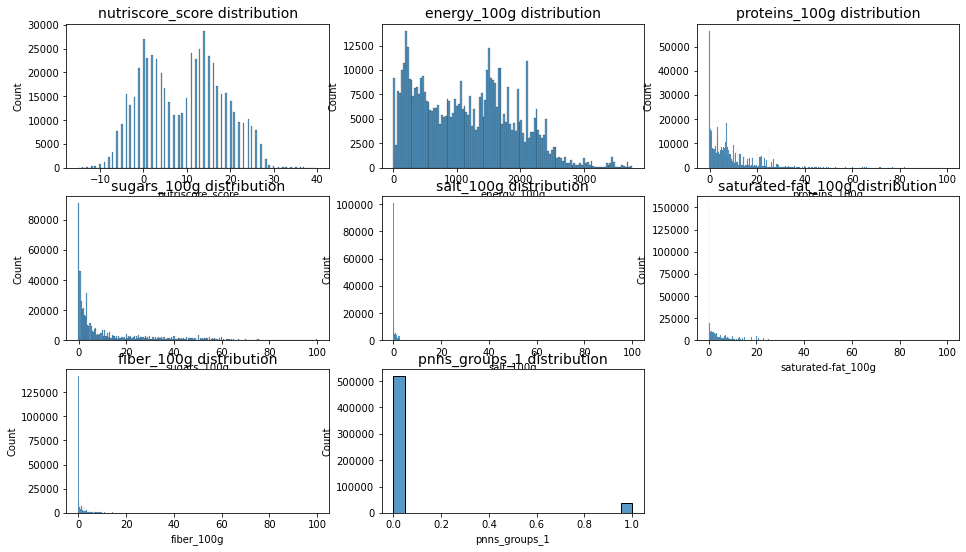

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def distributions(data):
    
    features = data.columns[data.dtypes == 'float64']
    
    fig = plt.figure(figsize = (16,9))
    
    for i, feature in enumerate(features):
        g = fig.add_subplot(3,3, i+1)
        g = sns.histplot(x = feature, 
                    data = data)
        g.set_title(feature + ' distribution', fontsize = 14)

distributions(data)

The distributions of features don't look Gaussian.

Most are skewed to the right, with a relatively low number of samples with high values compared to the majority.

#### Bivariate

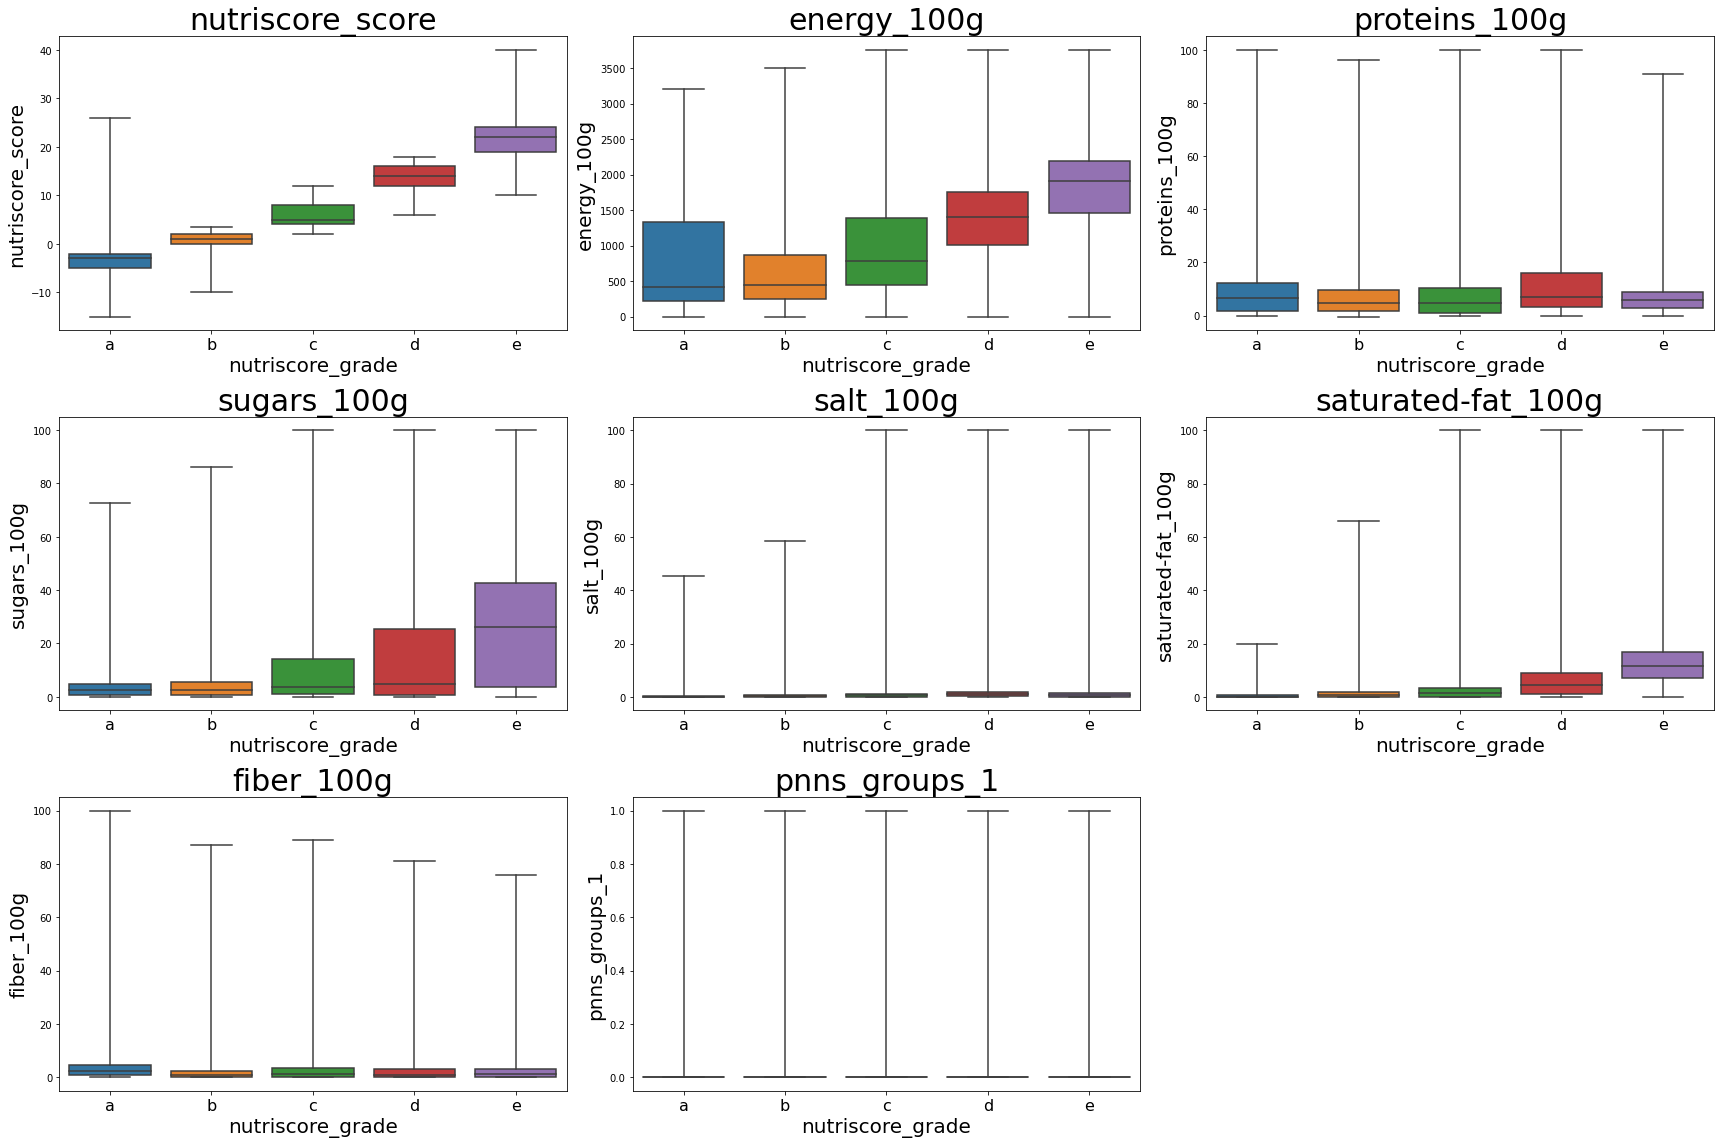

In [11]:
def conditional_dist(data):

    features = data.columns[data.dtypes == 'float64'].tolist()
    
    fig = plt.figure(figsize = (24,16))
    
    for i, feature in enumerate(features):
        g = fig.add_subplot(3,3,i+1)
        g = sns.boxplot(x = 'nutriscore_grade',y = feature, data = data, 
                    order = ['a', 'b', 'c', 'd', 'e'], whis = [0,100])
        g.set_title(feature, fontsize = 30)
        g.set_xlabel('nutriscore_grade', fontsize = 20)
        g.set_ylabel(feature, fontsize = 20)
        plt.xticks(fontsize = 16)
    plt.tight_layout()
        

conditional_dist(data)

The boxplots suggest that there is a dependency between the target and some of the features.
Products with 'e' grade tend to have higher quantities of saturated fat or sugars which is consistent with the correlation test done above.

Since more than one feature seems to have predictive power, we must ensure they are not redundant, so each will help improve the model performance.

One way is to visualize and interpret linear correlation between features with both PCA and correlation matrix.

Pearson correlation as well as PCA assume Gaussian distribution which is not the case here. However, applying these tools here may help us to get better insight of our data.

#### PCA

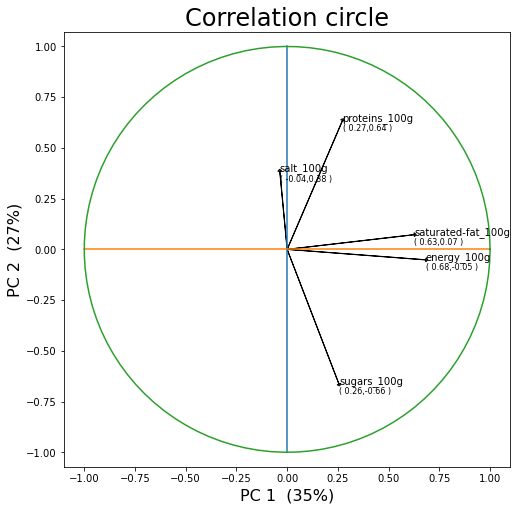

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

def corr_circle(data):
    
    ### Identify nutritional features
    features = ['energy_100g', 'proteins_100g','salt_100g',
       'sugars_100g', 'saturated-fat_100g']
    
    data = data[features]
    
    
    ### instantiate pipeline with scaler & PCA then fit pipeline 
    pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])
    pipe.fit(data)
    
    ### fitted PCA to address components coordinates on feature space
    pca = pipe.named_steps['pca']
    
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111)
    
    for i, feature in enumerate(features):
        
        ### for a given feature the arrow coordinates are coefs 
        ### on first & second component by explained variance
        ax.arrow(0,0, pca.components_[0, i], 
            pca.components_[1,i], 
        head_width = 0.02, 
        head_length = 0.01)
        
        ### Include feature label
        ax.text(pca.components_[0,i], 
    pca.components_[1,i], 
    feature, fontsize = 10)
        
        ### Include coordinates on PCs next to feature label
        ax.text(pca.components_[0,i], 
    pca.components_[1,i] - 0.05, 
        '( ' + str(pca.components_[0,i].round(decimals = 2)) + ',' 
    + str(pca.components_[1,i].round(decimals = 2)) + ' )', fontsize = 8)
    
    ### Plot x and y axis on the figure
    zeros = np.zeros(50)
    line = np.linspace(-1, 1, 50)
    ax.plot(zeros,line)
    ax.plot(line,zeros)
    
    an = np.linspace(0, 2 * np.pi, 100)
    ax.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
    plt.axis('equal')
    ax.set_ylabel(ylabel = 'PC 2' + '  '+ '(' + str("{:.0%}".format(pca.explained_variance_ratio_[1])) + ')', fontsize = 16)
    ax.set_xlabel(xlabel = 'PC 1' + '  '+ '(' + str("{:.0%}".format(pca.explained_variance_ratio_[0])) + ')', fontsize = 16)
    ax.set_title('Correlation circle', fontsize = 24)

corr_circle(data)

The variables best represented on the first axis are the amount of energy and saturated fat (higher coefficients). 

Axis 1 : 
- saturated fat & energy explain most of the variance of the samples (higher coefficients on axis)
- the direction of both features is likely the same which suggests positive linear correlation between these features


The most contributing variables to axis 2 are 'proteins' and 'sugars'. The arrows point in the opposite direction this time and seem to show a negative correlation between these two variables. This is confirmed by the correlation coefficient between the two variables, equal to -0.29.

#### Correlation matrix

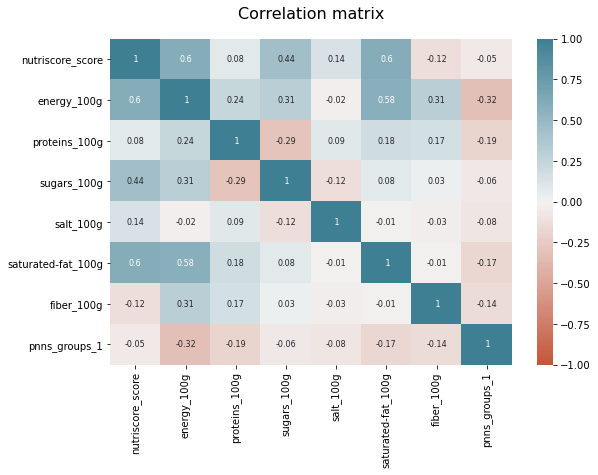

In [13]:
def corr_matrix(data):
    
    ### filter quantitative variables
    features = data.columns[data.dtypes == 'float64']
    data = data[features]
    
    corr_matrix = data.corr().round(decimals = 2)
    
    
    fig = plt.figure(figsize = (9,6))
    
    g = fig.add_subplot(111)
    
    palette = sns.diverging_palette(20, 220, n=256)
    
    g = sns.heatmap(corr_matrix, cmap = palette, vmin = -1, vmax = 1, 
            annot = True, fmt='2g', annot_kws={"size": 8})
    g.set_title('Correlation matrix', fontsize = 16, pad= 20)  
    plt.xticks(rotation = 90, fontsize = 10)    
    plt.yticks(fontsize = 10)


corr_matrix(data)



# Model : knn


- estimator : now that nutriscore has proven to be a reliable indicator, we will train an optimized kNN classifier that returns the target based on the amounts of each nutrient present in the product. The goal here is to evaluate the feasibility of an app that would return nutriscore.



- metric : we will use accuracy (percentage of correct predictions) as evaluation metric for the optimization and the comparison with a dummy model. Since the distribution of the target is fairly balanced and there is no priority to focus on certain classes accuracy is a good choice. 

## Knn vs dummy scores 

In [14]:
from sklearn.model_selection import train_test_split

### function that splits the data into train/test sets
def split_data(data):
    
    data = data.copy()
    
     
    X = data.select_dtypes('float64')
    X = X.drop('nutriscore_score', axis = 1)
    y = data['nutriscore_grade']
    
    ### Splitting
    X_train, X_test, y_train, y_test = train_test_split(X, 
    y, test_size=0.20)
    
    return X_train, X_test, y_train, y_test

In [15]:
X_train, X_test, y_train, y_test = split_data(data)

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.dummy import DummyClassifier

### Function that optimizes the k parameter of a kNN-classifier by CV on the train set
def knn_model(X, y, neighbors_range):
    
    X = X.copy()
    
    ### pipeline with scaler before distance-based kNN
    pipe = Pipeline([('scaler', StandardScaler()), 
        ('knn', KNeighborsClassifier())])
    
    ### optimizing k parameter with Grid
    param_grid = {'knn__n_neighbors' : neighbors_range}
    
    
    cv = StratifiedKFold(n_splits = 5, random_state = 42)
    
    ### Since target distribution is fairly distributed between labels  
    ### and there is no class priority in our predictions, accuracy is a good choice of metric 
    grid = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = cv, scoring = 'accuracy')
    grid.fit(X, y)
    
    print('Optimal n_neighbors parameter value: ' + str(grid.best_estimator_.named_steps['knn'].get_params()['n_neighbors']))
    
    
    
    
    
    fig = plt.figure(figsize = (16,6))
    
    ### append mean test accuracy score for each value of k 
    knn_scores = []
    grid_results_array = pd.DataFrame(grid.cv_results_)
    
    for i, k in enumerate(neighbors_range):
        score = grid_results_array.iloc[i][['split' + str(i) + '_test_score' for i in range(grid.n_splits_)]]
        knn_scores.append(score.mean())
    
    
    ax = fig.add_subplot(1,2,1)
    ax.plot(knn_scores, 
        markerfacecolor = 'blue', linestyle = 'dashed', markersize = 10,
        marker = 'o', color = 'red')
    ax.set_xticks(np.arange(0,len(neighbors_range), 1))
    ax.set_xticklabels(neighbors_range, fontsize = 12)
    ax.set_title('Knn', fontsize = 20)
    ax.set_ylabel('Accuracy', fontsize = 16)
    ax.set_xlabel('n_neighbors', fontsize = 16)
    
    
    ### Dummy model as baseline to evaluate kNN performance
    dummy = Pipeline([('scaler', StandardScaler()), 
        ('dummy', DummyClassifier(strategy = 'stratified', random_state = 42))])
    dummy_scores = cross_val_score(dummy, X, y, cv = cv, scoring = 'accuracy')
    
    
    ### Test scores for best knn
    
    best_knn_test_scores = grid_results_array.iloc[grid.best_index_][['split' + str(i) + '_test_score' 
    for i in range(grid.n_splits_)]]
    
    ### Plots accuracy result on each fold
    
    ax = fig.add_subplot(1,2,2)
    
    ax.bar(x = [0,1], height = [np.mean(best_knn_test_scores), np.mean(dummy_scores)], 
    color = ['blue', 'red'])
    ax.set_xticks(np.arange(0,2,1))
    ax.set_xticklabels(['Best knn', 'Dummy'], fontsize = 12)
    ax.set_title('Best Knn vs dummy', fontsize = 20, pad = 16)
    ax.set_ylabel('Accuracy', fontsize = 16)
    ax.set_xlabel('Estimators', fontsize = 16)
    ax.legend()
    
    model = grid.best_estimator_
    
    return model, best_knn_test_scores

Optimal n_neighbors parameter value: 3


No handles with labels found to put in legend.


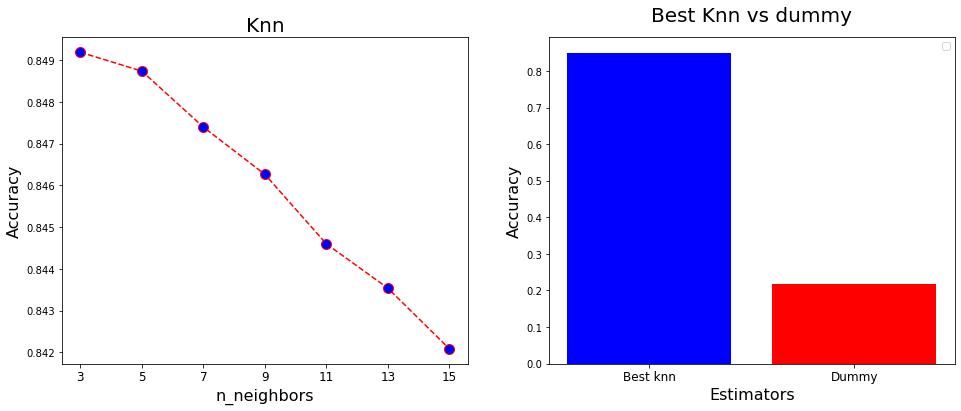

In [27]:
model, knn_scores = knn_model(X_train, y_train, [3,5,7,9,11,13,15])

The optimal n_neighbors parameter found by Grid is k = 5, with an accuracy score ~ 0.85.

kNN's performance is very superior to the DummyClassifier and consistent accross folds.

The features considered here are relevant here and enable training a robust classifier.

## Test vs validation

In [63]:
from sklearn.metrics import accuracy_score

### Function that returns predictions and compares metric value on test & validation sets
def predictions(X, y):
    
    ### predictions with fitted knn model
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    
    
    fig = plt.figure(figsize = (9,7))
    
    g = fig.add_subplot(111)
    
    ### Create df for seaborn barplot
    
    validation_df = pd.DataFrame(knn_scores.tolist(), columns = ['score'])
    validation_df['data'] = 'validation'
    
    test_df = pd.DataFrame([accuracy], columns = ['score'])
    test_df['data'] = 'test'
    
    df = pd.concat([validation_df, test_df])
    
    g = sns.barplot(x = 'data', y = 'score', data = df)
    g.set_title('test vs validation', fontsize = 20, pad = 16)
    g.set_ylabel('accuracy', fontsize = 16)
    g.set_xlabel('data', fontsize = 16)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    g.legend()
    
    return  y_pred

No handles with labels found to put in legend.


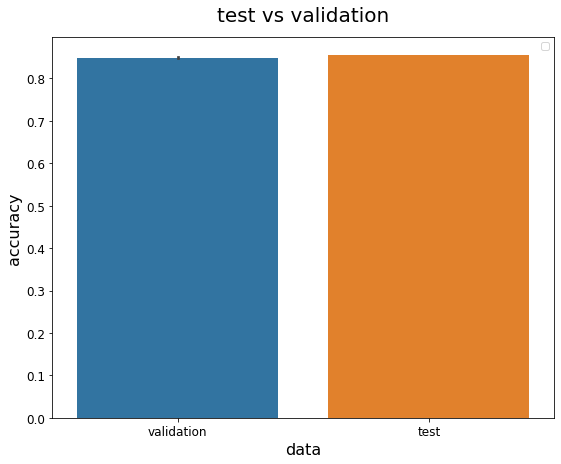

In [62]:
y_pred = predictions(X_test, y_test)

Performance on test set generalizes very well. Accuracy score on the test set is pretty much equal to the mean score on validation folds on the train set.

Let's see the confusion matrix to get better insights on predictions per class.

## Confusion matrix

In [20]:
from sklearn.metrics import confusion_matrix

def conf_matrix(y_true,y_pred):
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    fig = plt.figure(figsize = (7,6))
    
    g = fig.add_subplot(111)

    palette = sns.light_palette("navy")
    g = sns.heatmap(conf_matrix, annot = True, fmt='2g', annot_kws={"size": 12}, cmap = palette)

    g.set_yticklabels(labels = ['a', 'b', 'c', 'd', 'e'], fontsize = 16, rotation = 360)
    g.set_xticklabels(labels = ['a', 'b', 'c', 'd', 'e'], fontsize = 16)
    g.set_ylabel('Actual', fontsize = 16)
    g.set_xlabel('Predicted', fontsize = 16)
    g.set_title('Confusion matrix', fontsize = 20, pad = 16)

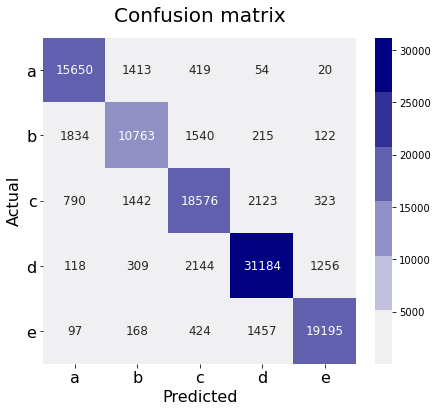

In [21]:
conf_matrix(y_test, y_pred)

The confusion matrix confirms visually the overall performance of the model. 
All classes seem to be predicted accurately. 

Further analysis shows that better predicted classes are extreme classes A, D and E.
For E label we get recall = 0.9 and precision = 0.91.

Least performing classes are B and C.

# Conclusion

* Our project of application is feasible. The good performance of the knn model confirms that we have the features necessary to train an accurate classifier.


* Beyond the overall performance of 85%, the model is efficient because the risk of a glaring error, i.e. of attributing a rating to a product that is quite far from its actual rating, is low.


* Further research could try to include new features such as vegetables quantity in food.
Also other estimators could be trained to improve the performance of the predictions.